# 제주도 도로 교통량 예측 AI 경진대회
> ### 배경 
제주도내 주민등록인구는 2022년 기준 약 68만명으로, 연평균 1.3%정도 매년 증가하고 있습니다.

또한 외국인과 관광객까지 고려하면 전체 상주인구는 90만명을 넘을 것으로 추정되며, 

제주도민 증가와 외국인의 증가로 현재 제주도의 교통체증이 심각한 문제로 떠오르고 있습니다.



> ### 주제
제주도 도로 교통량 예측 AI 알고리즘 개발



> ### 설명
제주도의 교통 정보로부터 도로 교통량 회귀 예측


> ### 주최 / 주관
주최: 제주 테크노파크, 제주특별자치도
주관: 데이콘


> ### 참가자격
일반인, 학생 등 누구나

> ### 평가 산식
MAE


In [259]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import gc

import matplotlib.pyplot as plt
import seaborn as sns

import requests
import xmltodict
import json

from datetime import datetime

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거
warnings.filterwarnings(action='ignore')

In [260]:
data_info = pd.read_csv("./data/data_info.csv")
data_info

,변수명,변수 설명
0,id,아이디
1,base_date,날짜
2,day_of_week,요일
3,base_hour,시간대
4,lane_count,차로수
5,road_rating,도로등급
6,multi_linked,중용구간 여부
7,connect_code,연결로 코드
8,maximum_speed_limit,최고속도제한
9,weight_restricted,통과제한하중


In [261]:
train['base_date'].min()

20210901

In [262]:
train['base_date'].max()

20220731

- train.csv : 2021년 9월 ~ 2022년 7월 정보
- test.csv : 2022년 8월 데이터만 존재
  
### 대회 목표
- 도로의 차량 평균 속도(km) 예측하기


---

### csv to parquet
- 메모리에 효율적인 데이터 유형을 사용하여 용량을 크게 줄이고 빠른 작업이 가능합니다.
- 모든 종류의 데이터(구조화된 데이터 테이블, 이미지, 비디오, 문서)를 저장하는 데 적합하다.

In [222]:
def csv_to_parquet(csv_path, save_name):
    df = pd.read_csv(csv_path)
    df.to_parquet(f'./data/{save_name}.parquet')
    del df
    gc.collect()
    print(save_name, 'Done.')

In [223]:
csv_to_parquet('./data/train.csv', 'train')
csv_to_parquet('./data/test.csv', 'test')

train Done.
test Done.


### 데이터 불러오기

In [224]:
train = pd.read_parquet('./data/train.parquet')
test = pd.read_parquet('./data/test.parquet')

In [225]:
train.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
0,TRAIN_0000000,20220623,목,17,1,106,지방도1112호선,0,0,60.0,...,3,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0
1,TRAIN_0000001,20220728,목,21,2,103,일반국도11호선,0,0,60.0,...,0,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0
2,TRAIN_0000002,20211010,일,7,2,103,일반국도16호선,0,0,80.0,...,0,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0
3,TRAIN_0000003,20220311,금,13,2,107,태평로,0,0,50.0,...,0,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0
4,TRAIN_0000004,20211005,화,8,2,103,일반국도12호선,0,0,80.0,...,0,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0


## EDA & Feature Engineering

결측치 확인

In [226]:
train.isnull().sum()

id                       0
base_date                0
day_of_week              0
base_hour                0
lane_count               0
road_rating              0
road_name                0
multi_linked             0
connect_code             0
maximum_speed_limit      0
vehicle_restricted       0
weight_restricted        0
height_restricted        0
road_type                0
start_node_name          0
start_latitude           0
start_longitude          0
start_turn_restricted    0
end_node_name            0
end_latitude             0
end_longitude            0
end_turn_restricted      0
target                   0
dtype: int64

- 결측치 없는줄 알았는데 road_name에서 주의점 발견

In [227]:
train['road_name'].value_counts()

road_name
일반국도12호선    1046092
-            569463
일반국도16호선     554510
일반국도95호선     248181
일반국도11호선     215701
             ...   
애원로            7718
아봉로            7342
남조로            6813
호서중앙로          2819
호근로             587
Name: count, Length: 61, dtype: int64

start_node_name과 end_node_name으로 고유 도로 만들기

In [228]:
train[(train['start_node_name'] == '가동') & (train['end_node_name'] != '나동')][['start_node_name','end_node_name']]

,start_node_name,end_node_name
431,가동,수원씽크공장
1440,가동,원일공사
1555,가동,수원씽크공장
1886,가동,원일공사
3681,가동,원일공사
...,...,...
4697581,가동,원일공사
4698463,가동,원일공사
4699923,가동,수원씽크공장
4699926,가동,수원씽크공장


In [229]:
train['start_end_node_name'] = train['start_node_name'].astype(str) + '-' + train['end_node_name'].astype(str)
test['start_end_node_name'] = test['start_node_name'].astype(str) + '-' + test['end_node_name'].astype(str)

train.drop(["start_node_name", "end_node_name", "road_name"], axis = 1, inplace = True)
test.drop(["start_node_name", "end_node_name", "road_name"], axis = 1, inplace = True)

한가지 값만 존재하는 컬럼 찾기

In [230]:
one_value = []
for i in train.columns:
    if len(train[i].value_counts()) <2:
        one_value.append(i)
one_value

['vehicle_restricted', 'height_restricted']

해당 컬럼 삭제
- vehicle_restricted
- height_restricted

In [231]:
# 해당 컬럼 삭제
train.drop(["vehicle_restricted", "height_restricted"], axis = 1, inplace = True)
test.drop(["vehicle_restricted", "height_restricted"], axis = 1, inplace = True)

상관관계 그래프

In [33]:
from sklearn.preprocessing import LabelEncoder

items =  ['day_of_week', 'road_name', 'start_node_name', 'start_turn_restricted', 'end_node_name', 'end_turn_restricted']
train_label = train.copy()
encoder = LabelEncoder()

for i in items:
    encoder = LabelEncoder()
    encoder.fit(train_label[i])
    train_label[i] = encoder.transform(train_label[i])

train_label = train_label.drop("id", axis=1)

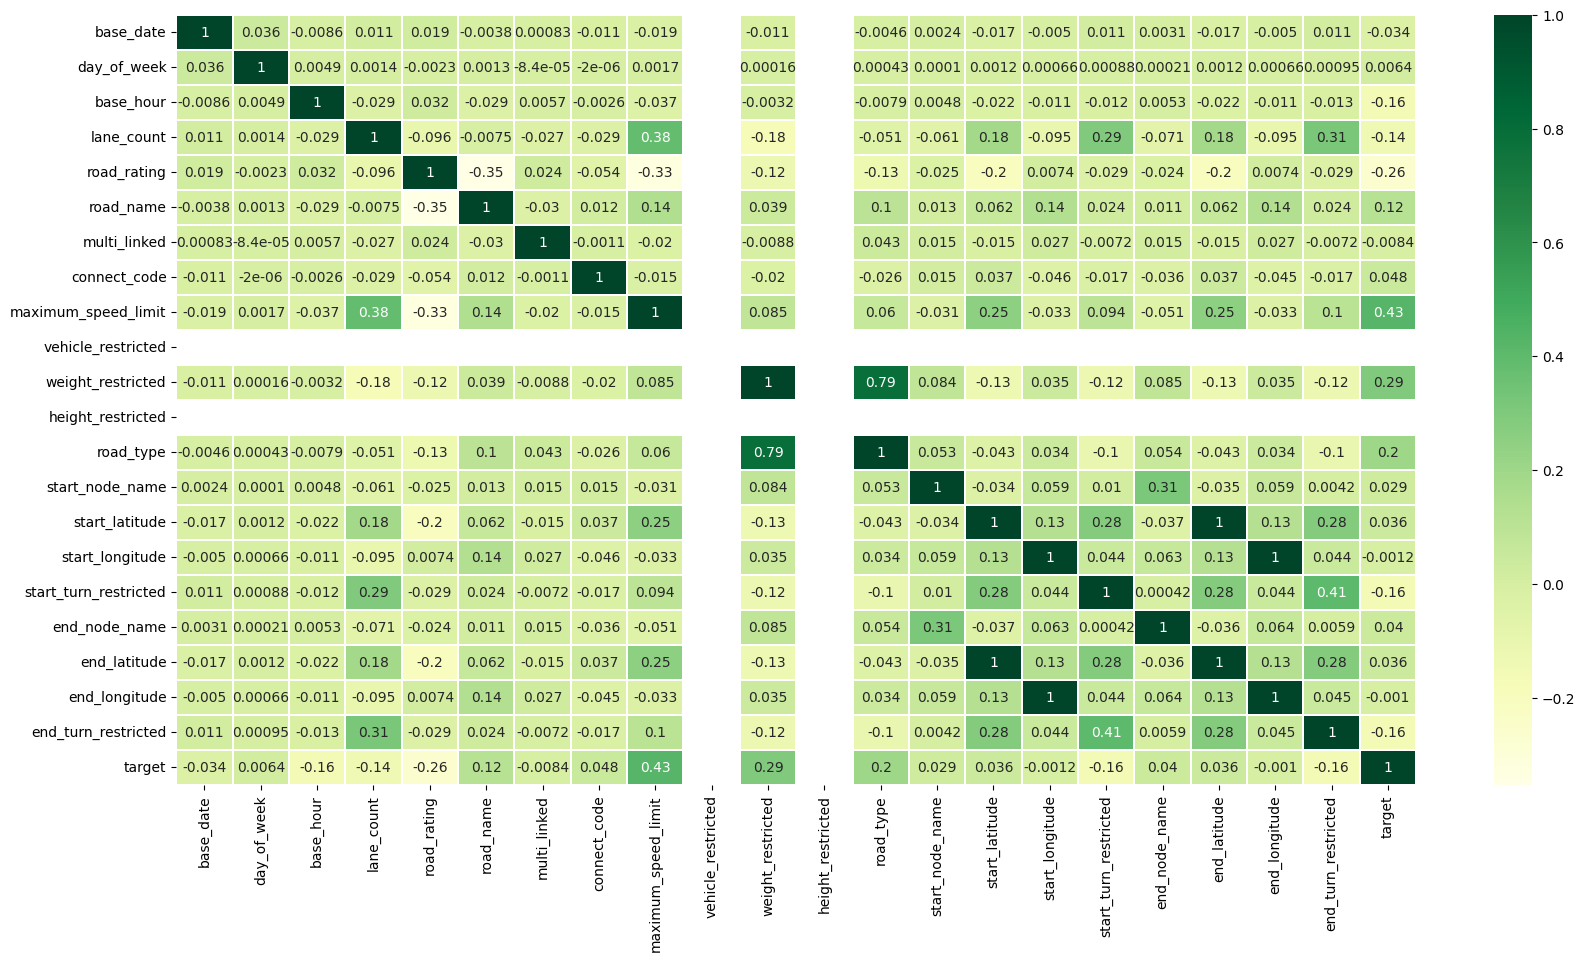

In [9]:
plt.figure(figsize=(20,10))
sns.heatmap(train_label.corr(), linewidths = 0.1, vmax = 1.0, cmap = 'YlGn', linecolor = "white",annot=True)
plt.show()

그래프를 통해 다음의 컬럼과 상관관계를 가진다고 판단
- maximum_speed_limit
- weight_restricted 
- road_type 

### maximum_speed_limit vs target 
maximum_speed_limit : 도로의 최고속도제한

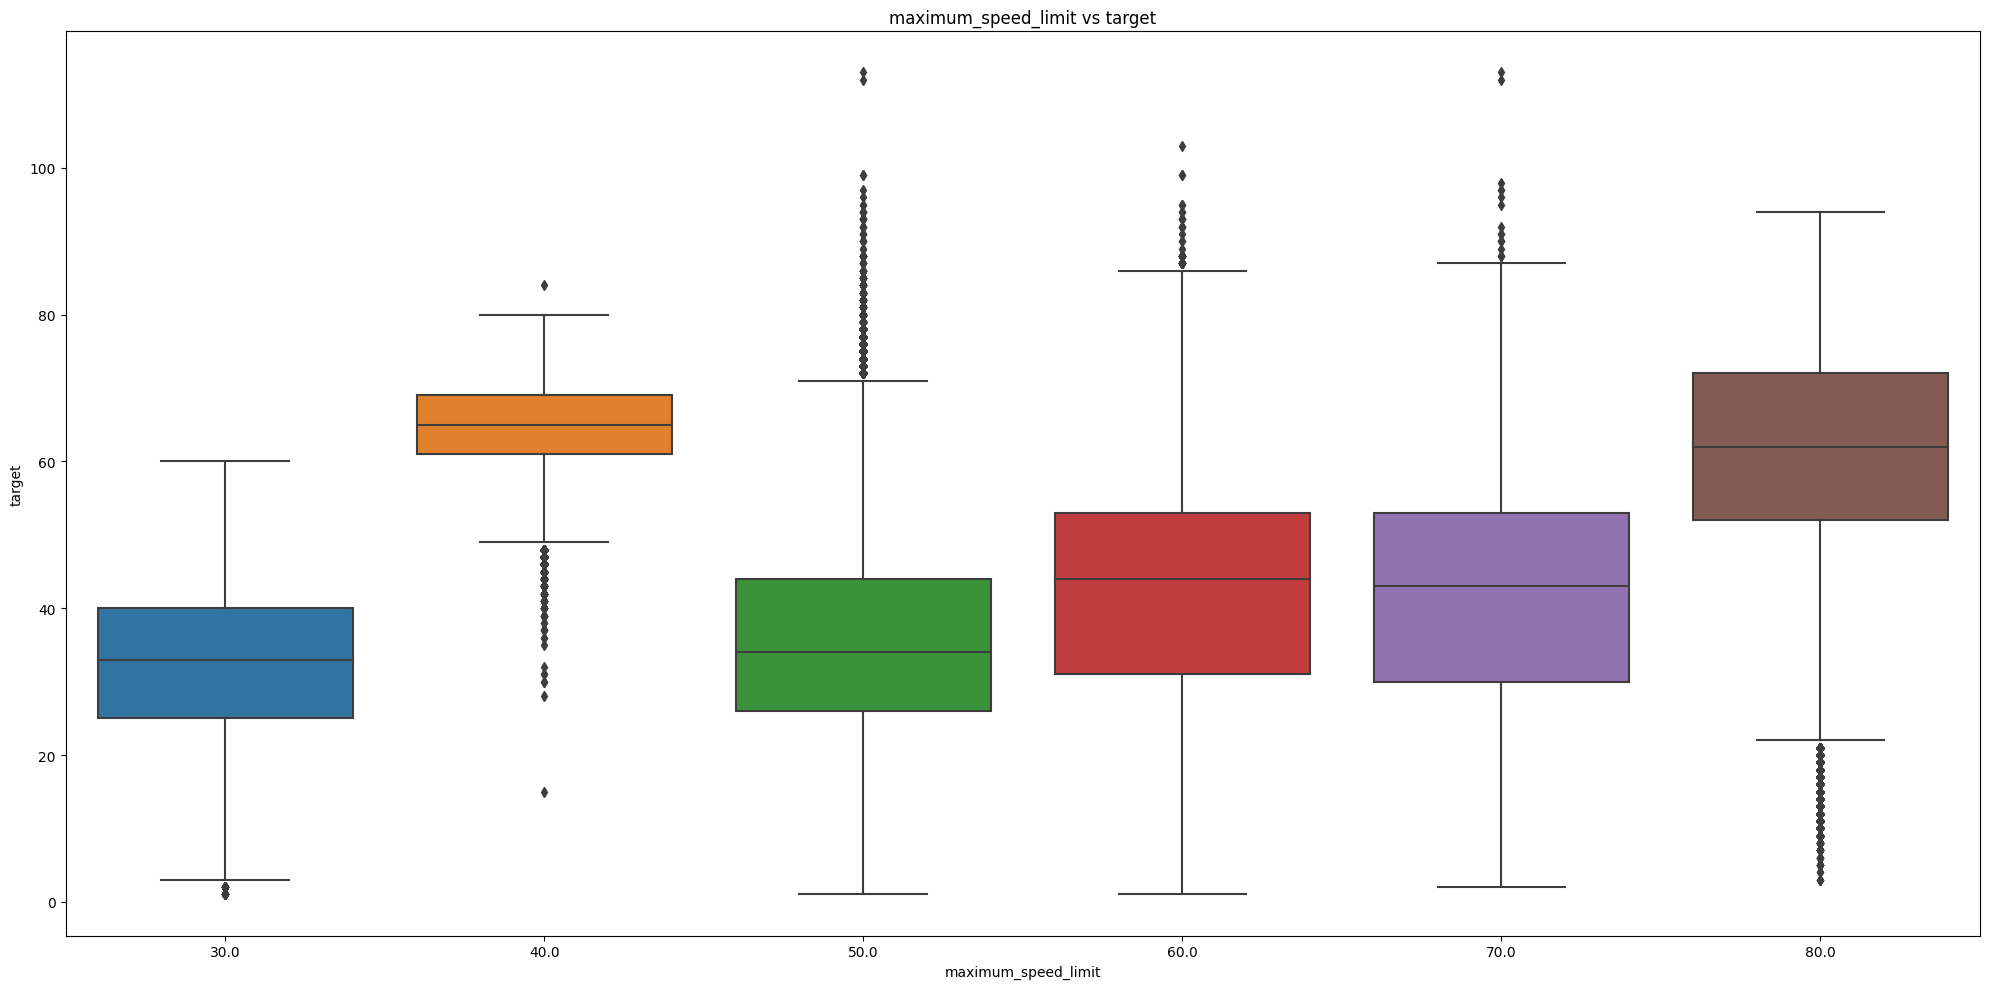

In [7]:
plt.figure(figsize=(20,10))
sns.boxplot(x='maximum_speed_limit',y='target',data=train).set(title='maximum_speed_limit vs target')
plt.tight_layout()
plt.show()

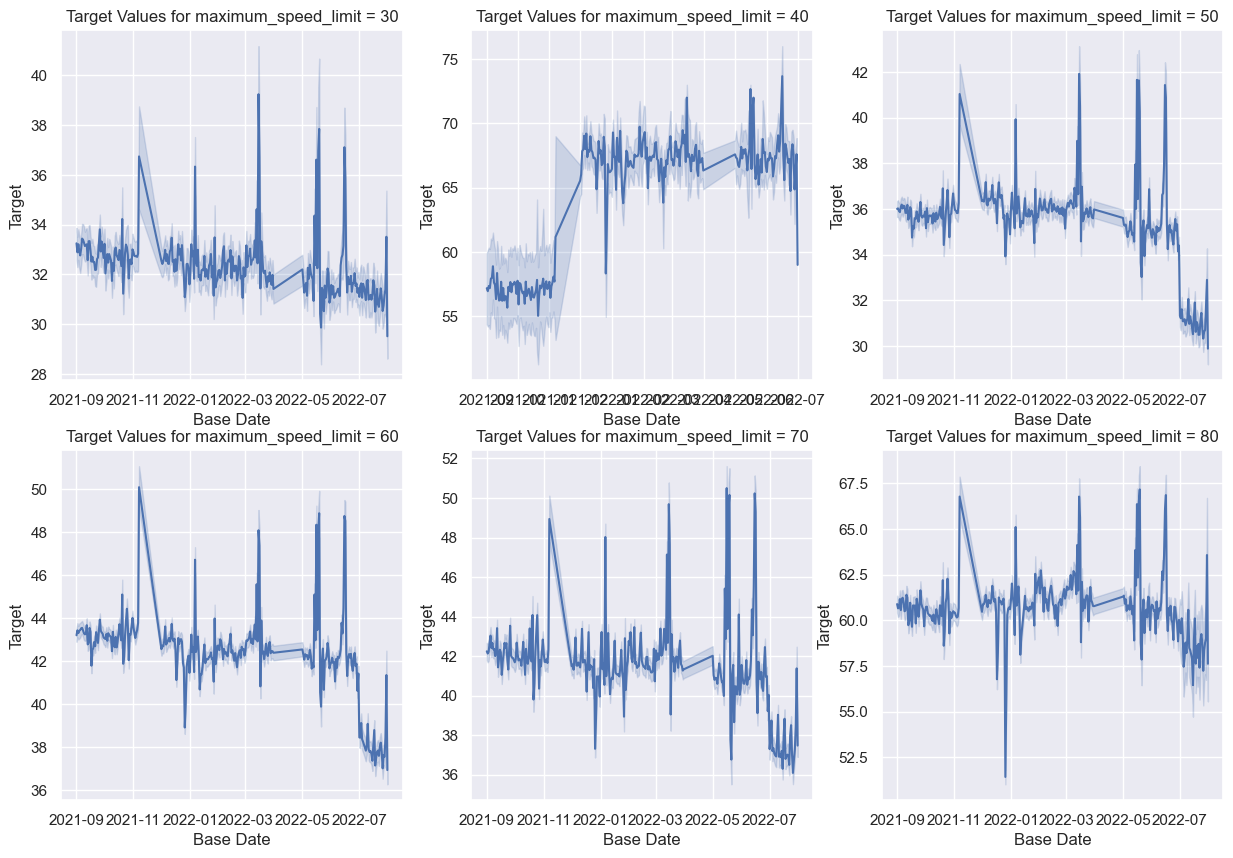

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [22]:
# fig, axes = plt.subplots(2, 3, figsize=(15, 10))
# row = 0
# col = 0
# for i in range(6):
#     speed = 30 + (i*10)
#     filtered_df = train[train['maximum_speed_limit'] == speed]
#     filtered_df["datetime"] = pd.to_datetime(filtered_df["base_date"],format='%Y%m%d')
#     # 시각화 설정
#     sns.set(style="darkgrid")
#     plt.figure(figsize=(10, 6))

#     # 시계열 그래프 플롯
#     sns.lineplot(x='datetime', y='target', data=filtered_df, ax=axes[row, col])

#     axes[row, col].set_title(f'Target Values for maximum_speed_limit = {speed}')
#     axes[row, col].set_xlabel('Base Date')
#     axes[row, col].set_ylabel('Target')

#     # 다음 서브플롯 인덱스 계산
#     col += 1
#     if col == 3:
#         row += 1
#         col = 0

# # 그래프 사이 간격 조정
# plt.tight_layout()
# plt.show()

- 시속별로 교통량이 다른것을 확인할 수 있다.
- 특이사항은 40에서 target이 커짐. 데이터 작아서..?

In [33]:
train['maximum_speed_limit'].value_counts()

maximum_speed_limit
60.0    1665573
50.0    1103682
70.0     995077
80.0     700334
30.0     229761
40.0       6790
Name: count, dtype: int64

### maximum_speed_limit 40 도로에서의 
### base hour vs target

[Text(0.5, 1.0, 'base_hour vs target')]

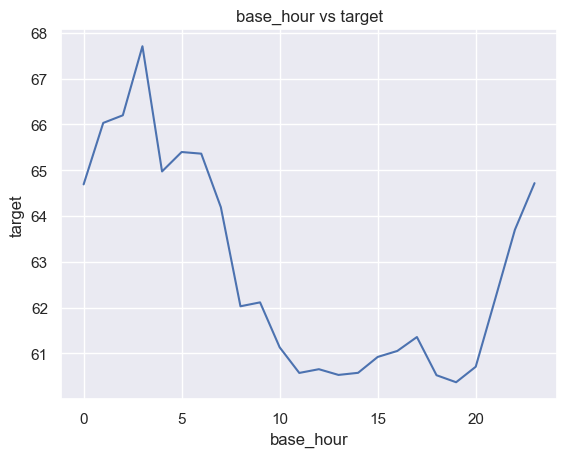

In [232]:
speed_limit_40  = train[train['maximum_speed_limit'] == 40]
speed_limit_40_time = speed_limit_40[['base_hour','target']]
speed_limit_40_time = speed_limit_40_time.groupby('base_hour').mean().reset_index()

sns.lineplot(x='base_hour',y='target',data=speed_limit_40_time).set(title='base_hour vs target')

### maximum_speed_limit 50에서의 동일그래프

[Text(0.5, 1.0, 'base_hour vs target')]

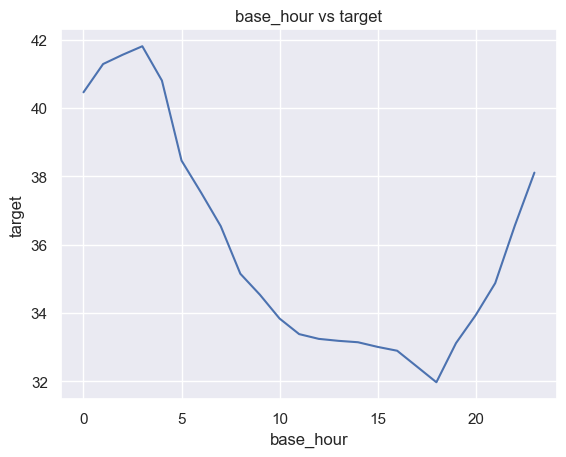

In [134]:
speed_limit_50  = train[train['maximum_speed_limit'] == 50]
speed_limit_50_time = speed_limit_50[['base_hour','target']]
speed_limit_50_time = speed_limit_50_time.groupby('base_hour').mean().reset_index()

sns.lineplot(x='base_hour',y='target',data=speed_limit_50_time).set(title='base_hour vs target')

제주도의 치한문제..? 어떤 도로길래

In [135]:
speed_limit_40['target'].max()

84.0

In [233]:
speed_limit_40_sorted = speed_limit_40.sort_values('target', ascending=False)[['start_end_node_name','target','base_date']]
speed_limit_40_sorted.groupby(['start_end_node_name']).mean().reset_index()

,start_end_node_name,target,base_date
0,양계장-구엄교,66.903359,2.021643e+07
1,전표1교-동광1교차로,47.712526,2.021098e+07


In [234]:
speed_limit_40_sorted.groupby(['start_end_node_name']).min('base_date').reset_index()

,start_end_node_name,target,base_date
0,양계장-구엄교,37.0,20210901
1,전표1교-동광1교차로,15.0,20210901


In [235]:
speed_limit_40_sorted.groupby(['start_end_node_name']).max('base_date').reset_index()

,start_end_node_name,target,base_date
0,양계장-구엄교,84.0,20220701
1,전표1교-동광1교차로,59.0,20211107


2021-11-07월 부터 전표1교-동광1교차로 도로는 속도 제한 40이 아니다.

In [142]:
train[(train['start_end_node_name'] == '전표1교-동광1교차로') & (train['maximum_speed_limit'] != 40)]

,id,base_date,day_of_week,base_hour,lane_count,road_rating,multi_linked,connect_code,maximum_speed_limit,weight_restricted,road_type,start_latitude,start_longitude,start_turn_restricted,end_latitude,end_longitude,end_turn_restricted,target,start_end_node_name


In [143]:
train[train['start_end_node_name'] == '전표1교-동광1교차로'].groupby(['start_end_node_name']).max('base_date').reset_index()


,start_end_node_name,base_date,base_hour,lane_count,road_rating,multi_linked,connect_code,maximum_speed_limit,weight_restricted,road_type,start_latitude,start_longitude,end_latitude,end_longitude,target
0,전표1교-동광1교차로,20211107,23,1,103,0,103,40.0,0.0,0,33.320921,126.35063,33.322851,126.351447,59.0



2021-11-07월 부터 전표1교-동광1교차로 도로의 데이터는 없다 

시속이 40인 두 지역에서 평균 target이 높이 나타나는 경향이 있다.
- 과속 레벨컬럼을 만들어 제한 속도대비 평균 속도의 초과 정도를 나타내는 컬럼 생성

In [236]:
overspeed = train.groupby('start_end_node_name')['target'].mean()- \
    train.groupby('start_end_node_name')['maximum_speed_limit'].mean()
overspeed = overspeed.reset_index()
overspeed = overspeed.rename(columns={0:'over_speed'})

In [237]:
overspeed.head()

,start_end_node_name,over_speed
0,BYC-김약국,-26.429977
1,BYC-정방수퍼,-23.102244
2,CU서귀호근로점-서호교회,-17.377688
3,KAL사거리-광양사거리,-36.077051
4,가는질-우사,-4.969691


In [238]:
# 양수값 추출
positive_values = overspeed[overspeed['over_speed'] > 0]['over_speed'].values

# 양수값 정렬
sorted_values = np.sort(positive_values)

# 4분위수 계산
q1 = np.percentile(sorted_values, 25)
q2 = np.percentile(sorted_values, 50)
q3 = np.percentile(sorted_values, 75)

# 'level' 컬럼 추가 및 값 할당
overspeed['over_speed_level'] = 0  # 음수에는 0 할당

overspeed.loc[(overspeed['over_speed'] <= q1) & (overspeed['over_speed'] >= 0), 'over_speed_level'] = 1
overspeed.loc[(overspeed['over_speed'] > q1) & (overspeed['over_speed'] <= q2), 'over_speed_level'] = 2
overspeed.loc[(overspeed['over_speed'] > q2) & (overspeed['over_speed'] <= q3), 'over_speed_level'] = 3
overspeed.loc[overspeed['over_speed'] > q3, 'over_speed_level'] = 4


In [239]:
overspeed[overspeed['start_end_node_name'] == '양계장-구엄교']

,start_end_node_name,over_speed,over_speed_level
438,양계장-구엄교,26.903359,4


In [240]:
overspeed[overspeed['start_end_node_name'] == '전표1교-동광1교차로']

,start_end_node_name,over_speed,over_speed_level
585,전표1교-동광1교차로,7.712526,3


In [241]:
train = train.merge(overspeed, on='start_end_node_name', how='left')
test = test.merge(overspeed, on='start_end_node_name', how='left')

### weight_restricted
- 가설: 통과 제한 하중이 높으면 무거운 차량이 적어지므로 속도 빨라질거다

In [11]:
train['weight_restricted'].value_counts()

weight_restricted
0.0        4032874
43200.0     410361
32400.0     239305
50000.0      18677
Name: count, dtype: int64

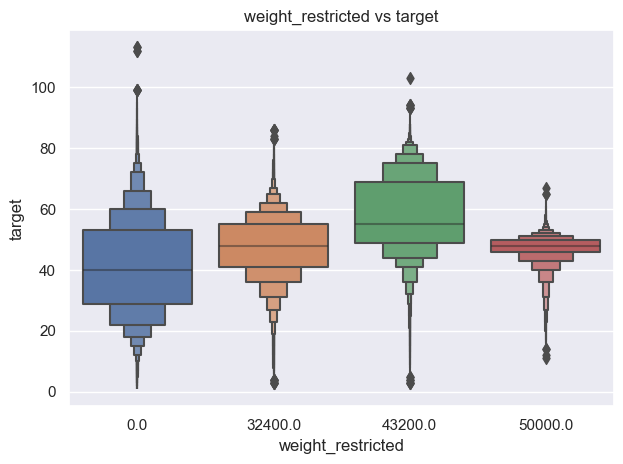

In [100]:
sns.boxenplot(x='weight_restricted',y='target',data=train).set(title='weight_restricted vs target')
plt.tight_layout()
plt.show()

- 통과제한 하중이 없으면 속도가 더 느려진다.
- 큰 차이를 보임

### road type

In [14]:
train['road_type'].value_counts()

road_type
0    3737117
3     964100
Name: count, dtype: int64

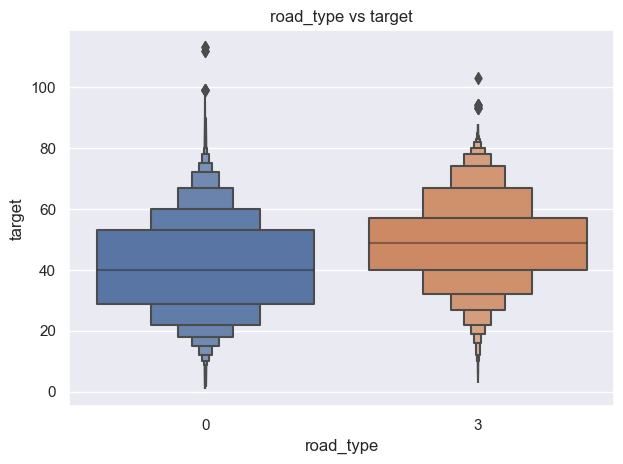

In [99]:
sns.boxenplot(x='road_type',y='target',data=train).set(title='road_type vs target')

plt.tight_layout()
plt.show()

### lane count (차로수)
- 가설 : 차로수가 많으면 속도가 더 빨라질것이다

In [89]:
train['lane_count'].value_counts()

lane_count
2    2352092
1    1558531
3     790594
Name: count, dtype: int64

<Axes: xlabel='lane_count', ylabel='target'>

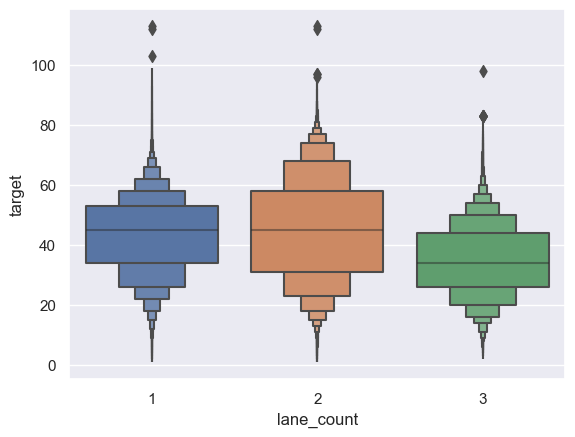

In [98]:
sns.boxenplot(x = train["lane_count"], y = train["target"])

<Axes: xlabel='target', ylabel='Count'>

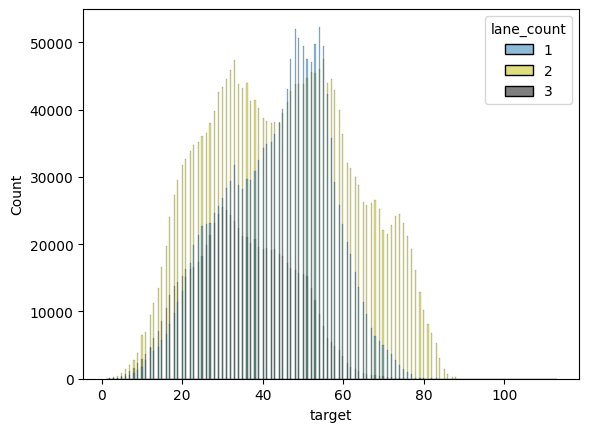

In [17]:
sns.histplot(x=train['target'], hue=train['lane_count'],palette=["C0", "y", "k"])

- 차선 증가하면 target 증가할 것이라 예상했지만, 오히려 감소
- 그래도 유의미한 차이가 존재한다고 판단

### road_rating (도로등급)
- 103: 일반국도
- 107: 시도 군도
- 106: 지방도

In [21]:
train.road_rating.value_counts()

road_rating
103    2159511
107    1582214
106     959492
Name: count, dtype: int64

<Axes: xlabel='road_rating', ylabel='target'>

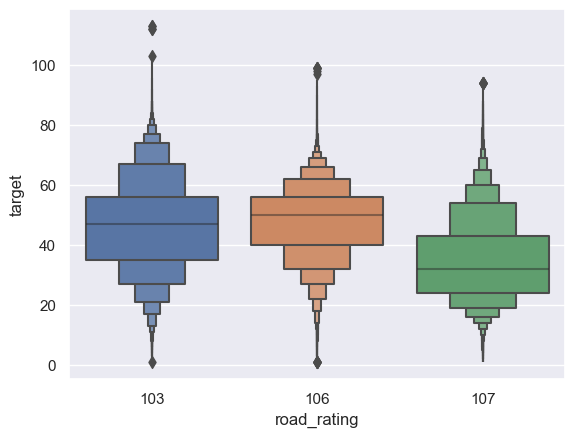

In [97]:
sns.boxenplot(x = train["road_rating"], y = train["target"])

- 107번(시도 군도) 에서 속도가 낮아지는 것을 알 수있음

### multi_linked (중용구간)
- 중용구간: 2개 이상의 노선이 도로의 일정 구간을 공동으로 사용하는 구간

In [22]:
train["multi_linked"].value_counts()

multi_linked
0    4698978
1       2239
Name: count, dtype: int64

<Axes: xlabel='multi_linked', ylabel='target'>

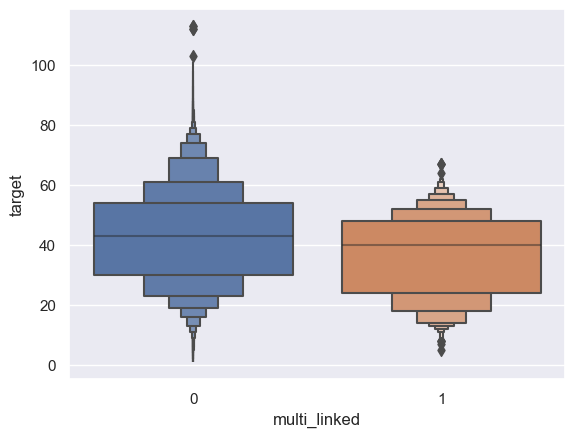

In [150]:
sns.boxenplot(x = train["multi_linked"], y = train["target"])

In [10]:
train.groupby("multi_linked")["target"].mean()

multi_linked
0    42.791370
1    36.642698
Name: target, dtype: float64

- multi_linked이 1인 값이 거의 존재하지 않는다.
- 뚜렷한 차이 또한 없다고 판단.
- multi_linked가 1인 도로중 road_type이 0인 도로는 존재하지 않는다.
- multi_linked 컬럼 삭제

In [21]:
train[(train["multi_linked"] == 1) & (train["road_type"] == 0)] 

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,datetime,year,month,day


In [242]:
train.drop(["multi_linked"], axis = 1, inplace = True)
test.drop(["multi_linked"], axis = 1, inplace = True)

### road_type

<Axes: xlabel='road_type', ylabel='target'>

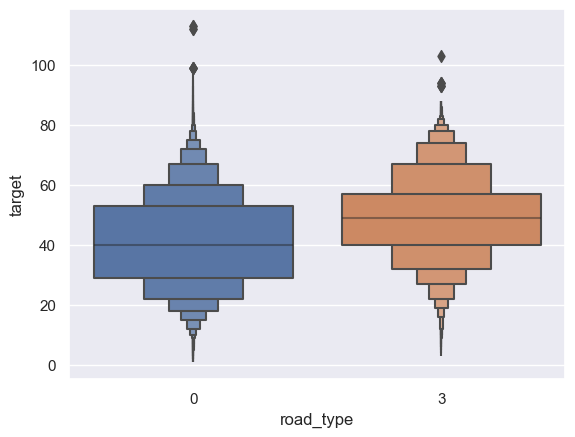

In [152]:
sns.boxenplot(x = "road_type", y = "target",data=train)

### connect_code
- 연결로: 입체교차하는 도로에서 서로 교차하는 도로를 연결하거나 서로 높이 차이가 있는 도로를 연결해 주는 도로를 말한다.
- 103: 고속도로 연결로

In [153]:
train["connect_code"].value_counts()

connect_code
0      4689075
103      12142
Name: count, dtype: int64

<Axes: xlabel='connect_code', ylabel='target'>

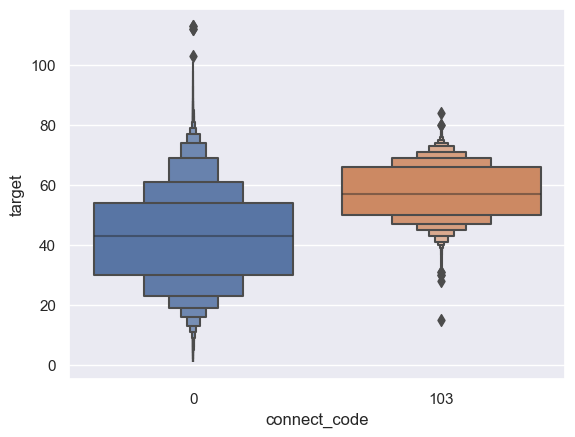

In [154]:
sns.boxenplot(x=train["connect_code"], y = train["target"])

In [155]:
train[(train["connect_code"] == 103) & (train["road_type"] == 1)] 

,id,base_date,day_of_week,base_hour,lane_count,road_rating,connect_code,maximum_speed_limit,weight_restricted,road_type,start_latitude,start_longitude,start_turn_restricted,end_latitude,end_longitude,end_turn_restricted,target,start_end_node_name,over_speed,over_speed_level


- 어느정도의 차이는 존재하지만 데이터 수의 차이가 너무 많이 난다.
- road_type이 1인 도로중 connect_code가 103인 도로는 존재하지 않는다.
- connect_code 삭제

In [ ]:
train.drop(["connect_code"], axis = 1, inplace = True)
test.drop(["connect_code"], axis = 1, inplace = True)

### start_turn_restricted & end_turn_restricted

In [243]:
train["start_turn_restricted"] = train["start_turn_restricted"].replace({"없음":0,"있음":1})
train["start_turn_restricted"].value_counts()

start_turn_restricted
0    4239701
1     461516
Name: count, dtype: int64

In [244]:
train["end_turn_restricted"] = train["end_turn_restricted"].replace({"없음":0,"있음":1})
train["end_turn_restricted"].value_counts()


end_turn_restricted
0    4239599
1     461618
Name: count, dtype: int64

<Axes: xlabel='start_turn_restricted', ylabel='target'>

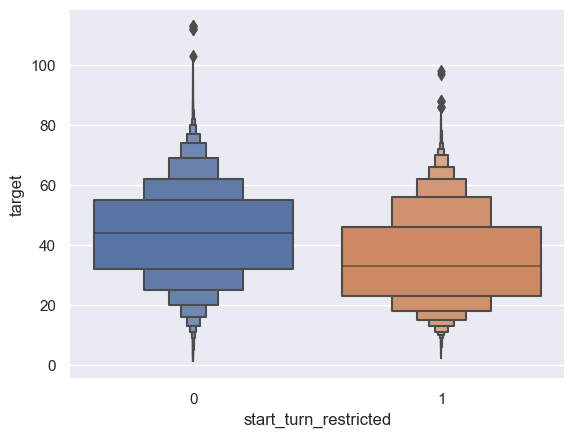

In [158]:
sns.boxenplot(x=train["start_turn_restricted"],y=train["target"])

<Axes: xlabel='end_turn_restricted', ylabel='target'>

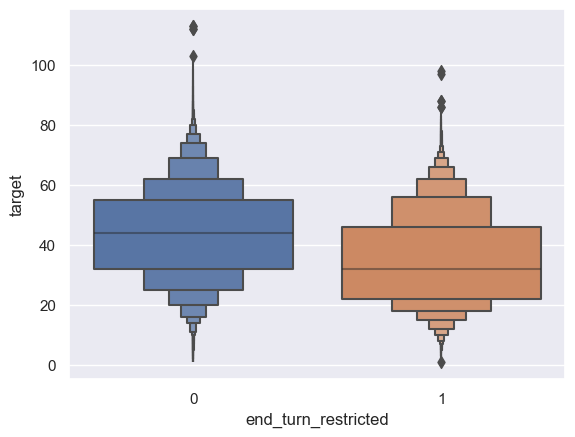

In [159]:
sns.boxenplot(x=train["end_turn_restricted"],y=train["target"])

### 년도/월/일별 추이 그래프

In [245]:
train["datetime"] = pd.to_datetime(train["base_date"],format='%Y%m%d')
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day

test["datetime"] = pd.to_datetime(test["base_date"],format='%Y%m%d')
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day

In [246]:
train_date = train[['datetime','target']]
train_date = train_date.groupby('datetime').mean().reset_index()

train_time = train[['base_hour','target']]
train_time = train_time.groupby('base_hour').mean().reset_index()

train_day = train[['day_of_week','target']]
train_day = train_day.groupby('day_of_week').mean()
train_day = train_day.reindex(['월','화','수','목','금','토','일']).reset_index()

train_time.loc[train_time['target'].idxmin(), 'base_hour']
train_day.head(7)


,day_of_week,target
0,월,42.761365
1,화,42.699198
2,수,42.770372
3,목,42.768345
4,금,42.450328
5,토,42.894117
6,일,43.179300


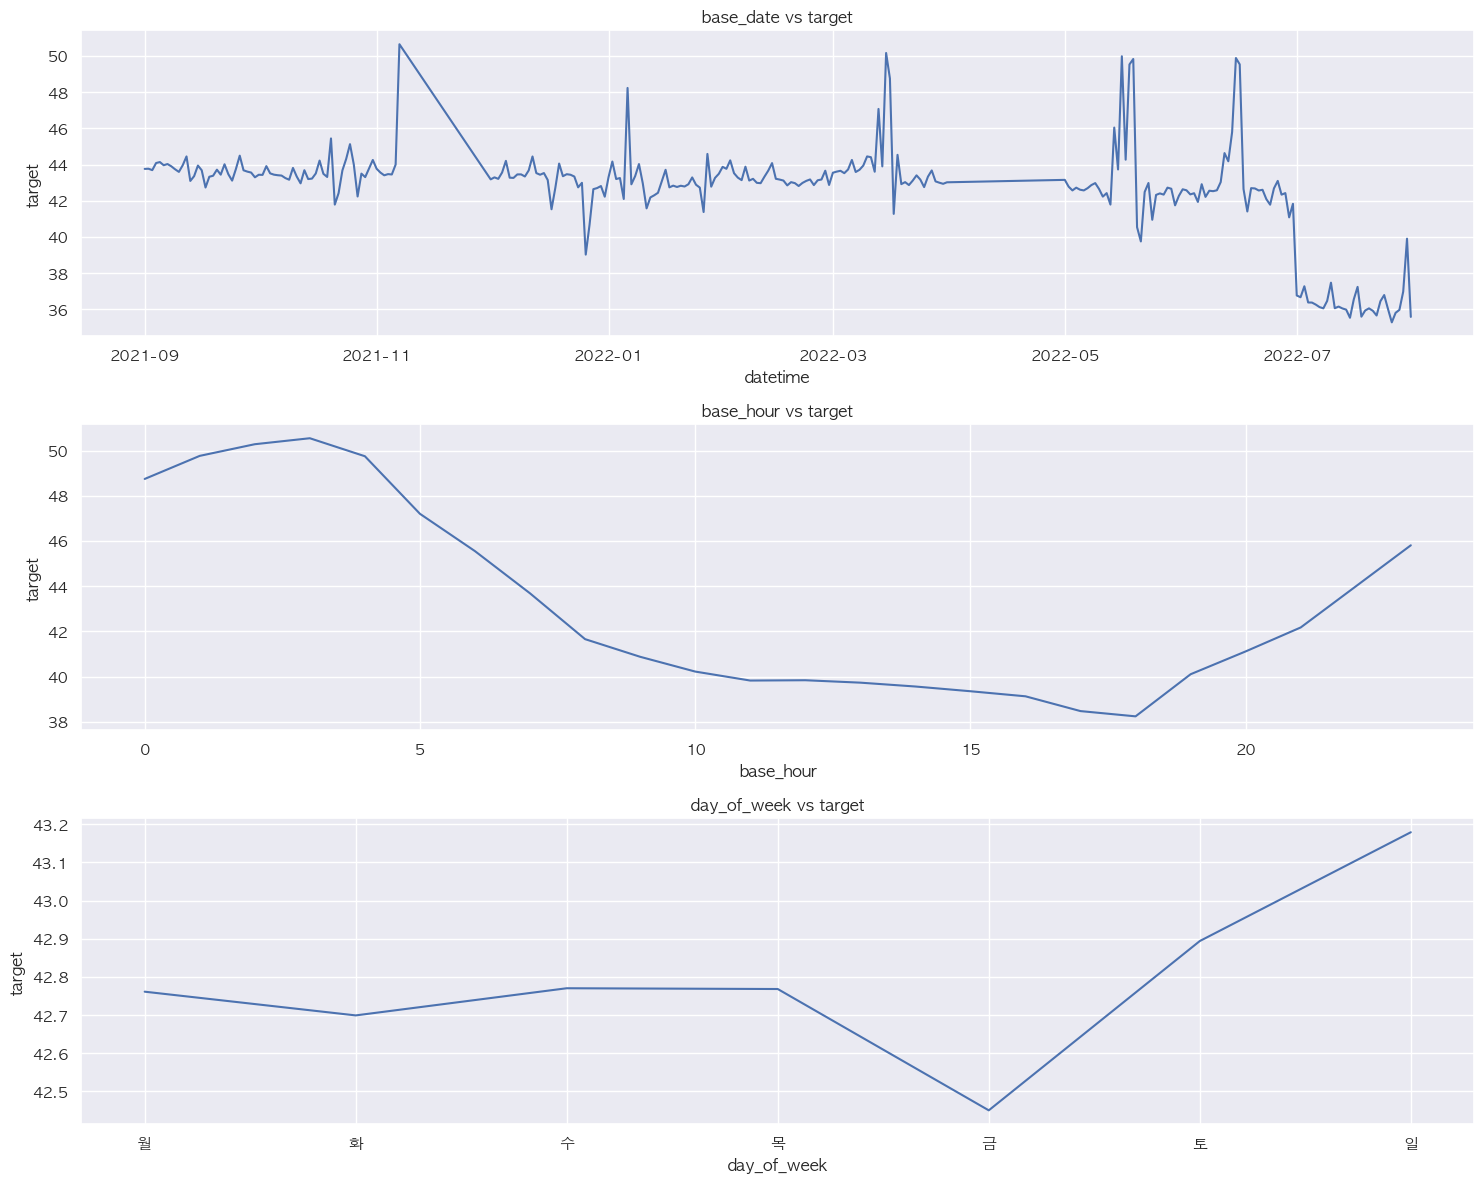

In [185]:
fig, axes = plt.subplots(3, figsize=(15,12))

sns.lineplot(x='datetime',y='target',data=train_date,ax=axes[0]).set(title='base_date vs target')
sns.lineplot(x='base_hour',y='target',data=train_time,ax=axes[1]).set(title='base_hour vs target')
sns.lineplot(x='day_of_week',y='target',data=train_day,ax=axes[2]).set(title='day_of_week vs target')

plt.rcParams['font.family'] = 'Darwin'
plt.tight_layout()
plt.show()

In [19]:
train[(train['year']==2021) & (train['month']==11) & (train['day'] > 7)]

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,connect_code,maximum_speed_limit,weight_restricted,...,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,datetime,year,month,day


In [20]:
train[(train['year']==2022) & (train['month']==4) & (train['day'] > 31)]

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,connect_code,maximum_speed_limit,weight_restricted,...,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,datetime,year,month,day


- 21년 11월, 22년 4월 데이터 비어있음
- 데이터가 1년 주기도 돌지 못하기에 년도의 주기성으로 분석하기는 힘들것이라 판단

### 시간 나누기

In [247]:
train.loc[(train['base_hour'] < 6), 'group_time'] = '새벽'
train.loc[(train['base_hour'] >=6) & (train['base_hour'] < 12), 'group_time'] = '아침'
train.loc[(train['base_hour'] >= 12) & (train['base_hour'] < 18), 'group_time'] = '점심'
train.loc[(train['base_hour'] >= 18) & (train['base_hour'] <= 24), 'group_time'] = '저녁'

test.loc[(test['base_hour'] < 6), 'group_time'] = '새벽'
test.loc[(test['base_hour'] >=6) & (test['base_hour'] < 12), 'group_time'] = '아침'
test.loc[(test['base_hour'] >= 12) & (test['base_hour'] < 18), 'group_time'] = '점심'
test.loc[(test['base_hour'] >= 18) & (test['base_hour'] <= 24), 'group_time'] = '저녁'

### 요일별 가중치 주기

In [248]:
# day_weight 컬럼 추가
train['day_weight'] = 0

train.loc[(train['day_of_week'] == '금'),'day_weight'] = 3
train.loc[(train['day_of_week'] == '토')|(train['day_of_week'] == '일'),'day_weight'] = 1
train.loc[(train['day_of_week'] == '월')|(train['day_of_week'] == '화')|\
    (train['day_of_week'] == '수')|(train['day_of_week'] == '목'),'day_weight'] = 2

test['day_weight'] = 0

test.loc[(test['day_of_week'] == '금'),'day_weight'] = 3
test.loc[(test['day_of_week'] == '토')|(test['day_of_week'] == '일'),'day_weight'] = 1
test.loc[(test['day_of_week'] == '월')|(test['day_of_week'] == '화')|\
    (test['day_of_week'] == '수')|(test['day_of_week'] == '목'),'day_weight'] = 2


### one hot encoding

In [ ]:
train = pd.get_dummies(train,columns=['day_of_week','group_time'])
test = pd.get_dummies(test,columns=['day_of_week','group_time'])

### Label Encoding


In [267]:
from sklearn.preprocessing import LabelEncoder

items =  ['day_of_week', 'group_time', 'start_turn_restricted', 'end_turn_restricted', 'start_end_node_name']
train_label = train.copy()
encoder = LabelEncoder()

for i in items:
    encoder = LabelEncoder()
    encoder.fit(train_label[i])
    train_label[i] = encoder.transform(train_label[i])


items =  ['day_of_week', 'group_time', 'start_turn_restricted', 'end_turn_restricted', 'start_end_node_name']
test_label = test.copy()
encoder = LabelEncoder()

for i in items:
    encoder = LabelEncoder()
    encoder.fit(test_label[i])
    test_label[i] = encoder.transform(test_label[i])


In [268]:
y_train = train_label['target'] 
X_train = train_label.drop(['id', 'target', 'datetime', 'base_date', 'day'], axis=1)

X_test = test_label.drop(['id', 'datetime', 'base_date', 'day'], axis=1)



print(X_train.shape)
print(y_train.shape)
print(test.shape)

(4701217, 23)
(4701217,)
(291241, 27)


### Feature Scaling

In [269]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(X_train)
X_train.loc[:, :] = scaler.transform(X_train)
X_test.loc[:, :] = scaler.transform(X_test)

X_test.head(2)

,day_of_week,base_hour,lane_count,road_rating,connect_code,maximum_speed_limit,weight_restricted,road_type,start_latitude,start_longitude,...,end_turn_restricted,start_end_node_name,over_speed,over_speed_level,year,month,group_time,day_weight,distance_from_airport_square,distance_from_seogwipo_square
0,-0.991029,0.754498,1.691525,1.109446,-0.050886,0.72087,-0.402678,-0.507917,1.137435,0.125438,...,3.030547,-1.228236,-1.313597,-0.278004,0.804187,0.450723,1.285684,0.218622,-1.161091,0.228943
1,1.506502,0.010682,0.237511,-1.064340,-0.050886,0.72087,-0.402678,1.968826,-1.243157,-0.605507,...,-0.329973,-0.313895,-0.232907,-0.278004,0.804187,0.450723,1.285684,0.218622,0.431154,-0.932570


### Train-Test Split

In [270]:
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_tr.shape, y_tr.shape)
print(X_val.shape, y_val.shape)

(3760973, 23) (3760973,)
(940244, 23) (940244,)


### Decision Tree

하이퍼 파라미터 튜닝
- max_depth (최대 깊이): 결정 트리의 최대 깊이를 지정
- min_samples_split (분할을 위한 최소 샘플 수): 노드를 분할하기 위해 필요한 최소 샘플 수를 지정

- min_samples_leaf (리프 노드의 최소 샘플 수): 리프 노드가 되기 위해 필요한 최소 샘플 수를 지정

- max_features (분할을 위해 고려할 특성의 최대 수): 각 분할에서 고려할 최대 특성의 수를 지정

In [ ]:
from sklearn.tree import DecisionTreeRegressor


model = DecisionTreeRegressor(random_state=42)

param_grid = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error', cv=5,verbose=10)
grid_search.fit(X_tr, y_tr)

# 최적의 하이퍼파라미터와 최적 성능 출력
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

# Decision Tree 모델 생성 및 학습
params = {'max_depth': None, 
            'max_features': None, 
            'min_samples_leaf': 4, 
            'min_samples_split': 10}

tree_model = DecisionTreeRegressor(random_state=42, **params)

tree_model.fit(X_tr, y_tr)

# 평가
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

print(f"tr mae: {mean_absolute_error(y_tr, tree_model.predict(X_tr))}")
print(f"val mae: {mean_absolute_error(y_val, tree_model.predict(X_val))}")
print(f"tr r2_score: {r2_score(y_tr, tree_model.predict(X_tr))}")
print(f"val r2_score: {r2_score(y_val, tree_model.predict(X_val))}")

In [204]:
tree_pred = tree_model.predict(X_test)
submission_tree = pd.read_csv('./data/sample_submission.csv')
submission_tree['target'] = tree_pred
submission_tree.to_csv("./data/submit_tree.csv", index = False)

### XGBoost

하이퍼 파라미터 튜닝
- learning_rate (학습률): 각 트리의 기여도를 조절하는 파라미터로, 새로운 트리의 예측값을 전체 모델에 추가할 때 사용

- n_estimators (트리 개수): 생성할 트리의 개수

- max_depth (최대 깊이): 생성되는 트리의 최대 깊이를 제한하는 파라미터입

- subsample (샘플링 비율): 각 트리를 학습할 때 사용되는 훈련 데이터의 샘플링 비율을 지정

- colsample_bytree (트리에 사용되는 특성 비율): 각 트리를 학습할 때 사용되는 특성의 비율을 지정

In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# XGBoost 모델 정의
model = xgb.XGBRegressor(random_state=42,)

# 하이퍼파라미터 그리드 정의
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# GridSearchCV를 사용하여 하이퍼파라미터 최적화
grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error', cv=5, verbose=10)
grid_search.fit(X_tr, y_tr)

# 최적의 하이퍼파라미터와 최적 성능 출력
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)

In [214]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

params = {'colsample_bytree': 1.0,
            'learning_rate': 0.1,
            'max_depth': 15,
            'n_estimators': 200,
            'subsample': 1.0}
            
xgb_model = xgb.XGBRegressor(random_state=42, **params)

# 조기 종료를 위한 검증 세트 설정
eval_set = [(X_tr, y_tr), (X_val, y_val)]

# 조기 종료 및 학습
xgb_model.fit(X_tr, y_tr,eval_set=eval_set,verbose=10)


# 평가
from sklearn.metrics import r2_score

print(f"val mae: {mean_absolute_error(y_val, xgb_model.predict(X_val))}")
print(f"val r2_score: {r2_score(y_val, xgb_model.predict(X_val))}")

[0]	validation_0-rmse:40.73479	validation_1-rmse:40.74750
[10]	validation_0-rmse:14.88501	validation_1-rmse:14.90824
[20]	validation_0-rmse:6.65126	validation_1-rmse:6.73697
[30]	validation_0-rmse:4.58797	validation_1-rmse:4.77755
[40]	validation_0-rmse:4.13320	validation_1-rmse:4.41099
[50]	validation_0-rmse:3.96837	validation_1-rmse:4.31863
[60]	validation_0-rmse:3.85746	validation_1-rmse:4.27538
[70]	validation_0-rmse:3.76506	validation_1-rmse:4.24476
[80]	validation_0-rmse:3.69815	validation_1-rmse:4.22432
[90]	validation_0-rmse:3.63953	validation_1-rmse:4.20870
[100]	validation_0-rmse:3.58622	validation_1-rmse:4.19522
[110]	validation_0-rmse:3.54558	validation_1-rmse:4.18554
[120]	validation_0-rmse:3.51503	validation_1-rmse:4.17950
[130]	validation_0-rmse:3.48428	validation_1-rmse:4.17475
[140]	validation_0-rmse:3.45919	validation_1-rmse:4.17031
[150]	validation_0-rmse:3.42564	validation_1-rmse:4.16371
[160]	validation_0-rmse:3.39125	validation_1-rmse:4.15852
[170]	validation_0-rm

In [216]:
from sklearn.metrics import r2_score

print(f"val mae: {mean_absolute_error(y_val, xgb_model.predict(X_val))}")
print(f"val r2_score: {r2_score(y_val, xgb_model.predict(X_val))}")

val mae: 2.84895942595372
val r2_score: 0.9325456224786791


### LightGBM

- 하이퍼 파라미터 튜닝

In [ ]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

model = lgb.LGBMRegressor(random_state=42)

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'num_leaves': [10, 20, 30],
    'max_depth': [5, 10, 15]
}

grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_search.fit(X_tr, y_tr)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)

In [ ]:
import lightgbm as lgb


params = {'learning_rate': 0.2,
                    'max_depth': 15,
                    'n_estimators': 200,
                    'num_leaves': 30}
LR = lgb.LGBMRegressor(random_state=42, **params).fit(X_tr, y_tr,eval_set=[(X_val, y_val)],verbose=10) 

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


# 최적의 에포크 수 확인
best_num_boost_round = LR.best_iteration_
print("Best number of boosting rounds:", best_num_boost_round)
print(f"val mae: {mean_absolute_error(y_val, LR.predict(X_val))}")
print(f"val r2_score: {r2_score(y_val, LR.predict(X_val))}")


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

rf_model = RandomForestRegressor(random_state=42,verbose=1)
rf_model.fit(X_tr, y_tr)

print(f"val mae: {mean_absolute_error(y_val, rf_model.predict(X_val))}")
print(f"val r2_score: {r2_score(y_val, rf_model.predict(X_val))}")

## 외부 데이터를 활용한 외생변수

### 공휴일 시각화

공휴일 데이터 불러오기

In [14]:
def get_holiday_data(year):
    url = 'http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService/getRestDeInfo'
    params = {
        'serviceKey': 'lUyD7/c6oiXRywzql7NJsMdnhrTjYOH+Rx/4siN3lV2/J2bWu4UfjpTnBTl150QccIo/8rglYGnTQW2XaKH81g==',
        'solYear': str(year),
        'numOfRows': '100' 
    }

    response = requests.get(url, params=params)
    xml_data = response.content
    json_data = json.dumps(xmltodict.parse(xml_data), indent=4)

    data = json.loads(json_data)

    items = data['response']['body']['items']['item']
    holiday_data = pd.DataFrame(items)

    return holiday_data

holiday_2021 = get_holiday_data(2021)
holiday_2022 = get_holiday_data(2022)

holiday_data = pd.concat([holiday_2021, holiday_2022],ignore_index=True)[['dateName','locdate']]
holiday_data["datetime"] = pd.to_datetime(holiday_data["locdate"],format='%Y%m%d')

holiday_data
# holiday_data.to_csv('./data/holiday.csv', index=False)

,dateName,locdate,datetime
0,1월1일,20210101,2021-01-01
1,설날,20210211,2021-02-11
2,설날,20210212,2021-02-12
3,설날,20210213,2021-02-13
4,삼일절,20210301,2021-03-01
5,어린이날,20210505,2021-05-05
6,부처님오신날,20210519,2021-05-19
7,현충일,20210606,2021-06-06
8,광복절,20210815,2021-08-15
9,대체공휴일,20210816,2021-08-16


In [15]:
# 공휴일이면 is_holiday에 'Y' 값 표시
train['is_holiday'] = train['datetime'].isin(holiday_data['datetime']).map({True: 'Y', False: 'N'})

- 데이터 확인 필요 없을수 있음

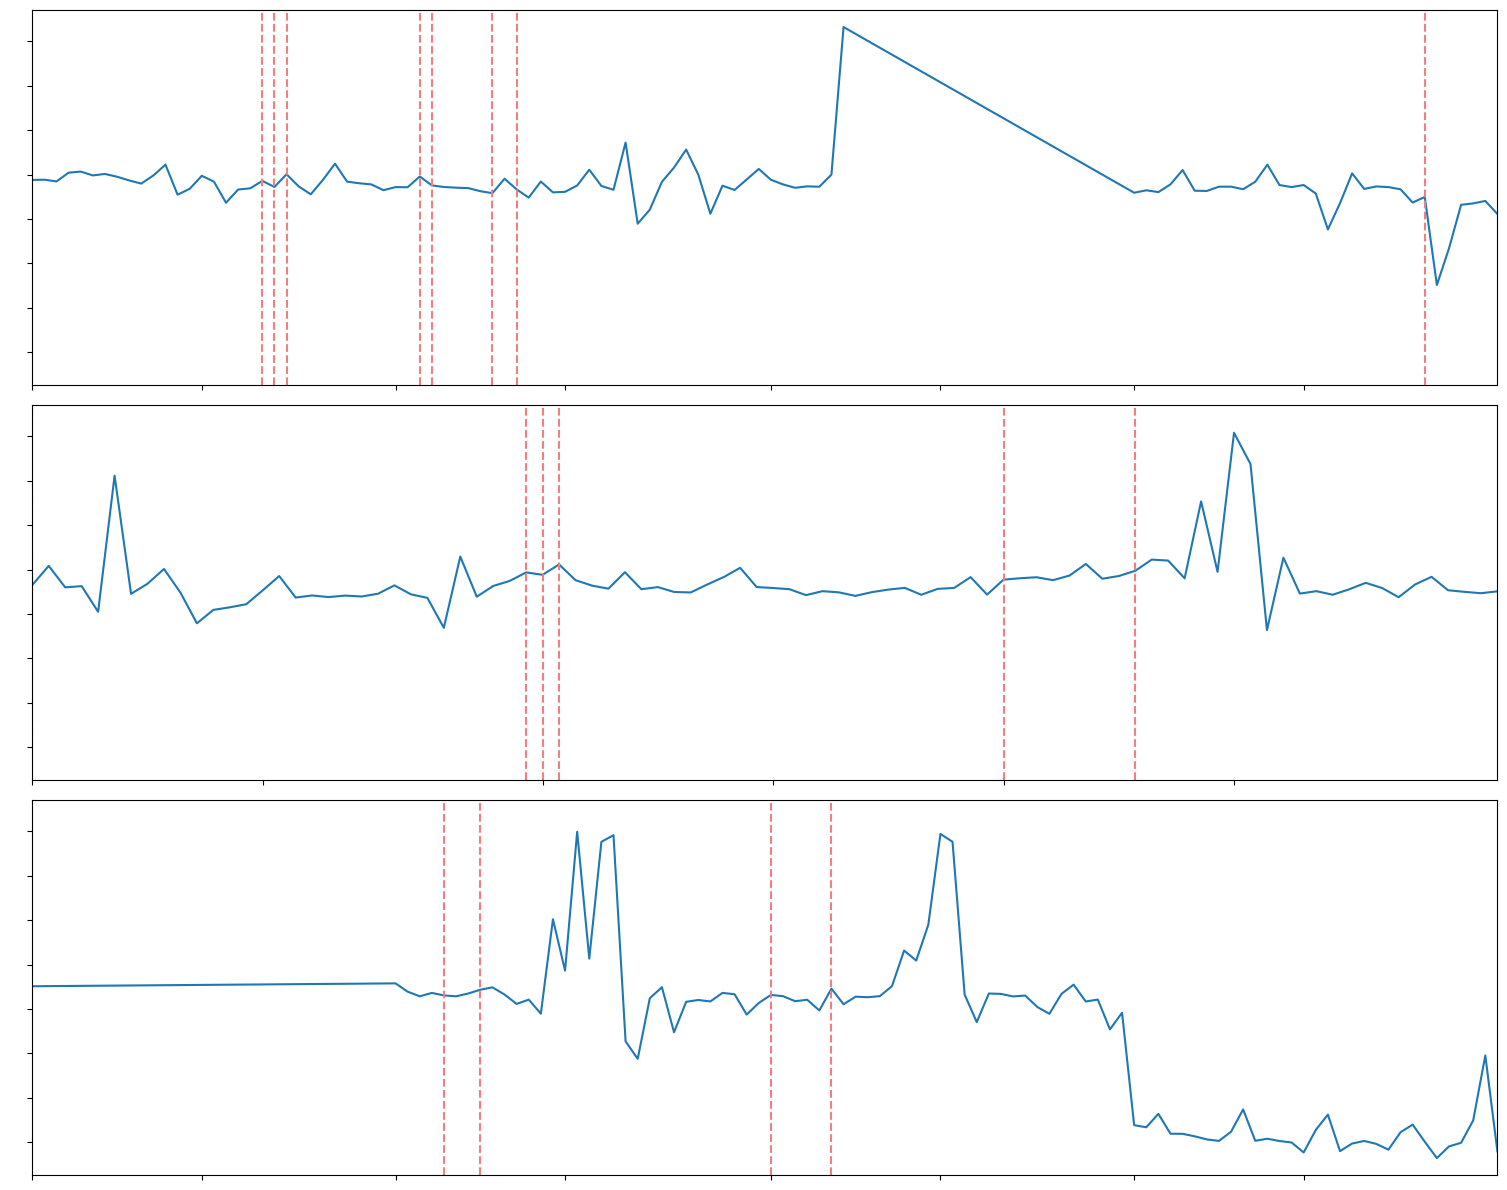

In [16]:
train_date = train[['datetime','target']]
train_date = train_date.groupby('datetime').mean().reset_index()
train_date['is_holiday'] = train_date['datetime'].isin(holiday_data['datetime']).map({True: 'Y', False: 'N'})

fig, axes = plt.subplots(3, figsize=(15,12))
sns.lineplot(x='datetime',y='target',data=train_date,ax=axes[0])
sns.lineplot(x='datetime',y='target',data=train_date,ax=axes[1])
sns.lineplot(x='datetime',y='target',data=train_date,ax=axes[2])

axes[0].set_xlim([datetime(2021, 9, 1), datetime(2021, 12, 31)])
axes[1].set_xlim([datetime(2022, 1, 1), datetime(2022, 3, 31)])
axes[2].set_xlim([datetime(2022, 4, 1), datetime(2022, 7, 31)])

for ax in axes:
    for _, row in train_date[train_date['is_holiday'] == 'Y'].iterrows():
        ax.axvline(x=row['datetime'], color='lightcoral', linestyle='--')

# plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

![한국도로공사](%ED%95%9C%EA%B5%AD%EB%8F%84%EB%A1%9C%EA%B3%B5%EC%82%AC.png)

### 기온,강수 - 교통량 

In [17]:
# 제주도 기온, 강수 csv 파일 불러오기
def read_csv_jeju(filename):
    filename = pd.read_csv(f"./data/{filename}.csv", encoding='euc-kr')
    filename['날짜'] = filename['날짜'].str.replace('\t','')
    filename["날짜"] = pd.to_datetime(filename["날짜"],format='%Y-%m-%d')
    filename = filename.rename(columns={'날짜':'datetime'})
    return filename

In [ ]:
temper = read_csv_jeju('temperature_jeju')[['datetime','평균기온(℃)']]
rain = read_csv_jeju('rain_jeju')[['datetime','강수량(mm)']]
rain['강수량(mm)'] = rain['강수량(mm)'].fillna(0)

In [ ]:
temp_rain = pd.merge(temper, rain, on='datetime', how='inner')
train = pd.merge(train, temp_rain, left_on='datetime', right_on='datetime', how='inner')
test = pd.merge(test, temp_rain, left_on='datetime', right_on='datetime', how='inner')

### 지도 시각화

In [6]:
gps = train[['start_longitude', 'end_longitude', 'start_latitude', 'end_latitude', 'target']]
gps_set = [gps['start_longitude'].min(), gps['start_longitude'].max(), gps['start_latitude'].min(), gps['start_latitude'].max()] # 지도 그림의 gps 좌표
gps_set

[126.182616549771, 126.930940973848, 33.2434317486804, 33.5560801767072]

In [7]:
vel_low_idx = gps.loc[gps['target']<15].index # 시내 교통 체증기준 15 km/h 미만
vel_high_idx = gps.loc[gps['target']>80].index # 고속도로 원활기준 80 km/h 초과

100%|██████████| 26239/26239 [00:10<00:00, 2606.04it/s]


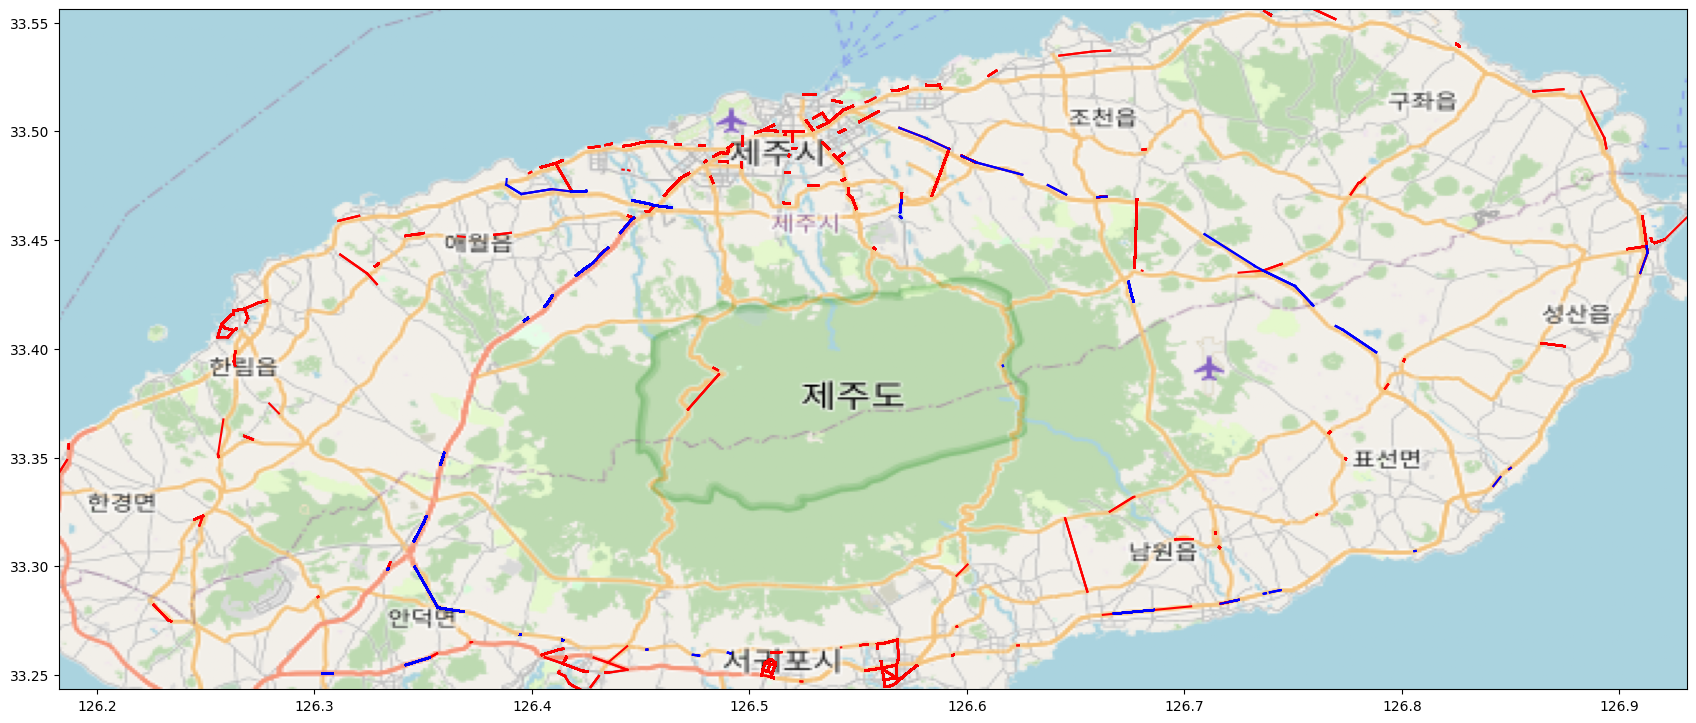

In [8]:
from tqdm import tqdm

f, ax = plt.subplots(figsize=(21,10))

ax.set_xlim(gps_set[0], gps_set[1])
ax.set_ylim(gps_set[2], gps_set[3])

image = plt.imread('map.png')
ax.imshow(image, zorder=0, extent=gps_set, aspect='equal')

for i in tqdm(vel_low_idx): # 교통 체증 도로 빨강
    x_1 = gps.loc[i,'start_longitude']
    x_2 = gps.loc[i,'end_longitude'] 
    y_1 = gps.loc[i,'start_latitude']
    y_2 = gps.loc[i,'end_latitude'] 
    ax.plot([x_1, x_2], [y_1, y_2], color='red')

for i in tqdm(vel_high_idx): # 교통 원활 도로 파랑
    x_1 = gps.loc[i,'start_longitude']
    x_2 = gps.loc[i,'end_longitude'] 
    y_1 = gps.loc[i,'start_latitude']
    y_2 = gps.loc[i,'end_latitude'] 
    ax.plot([x_1, x_2], [y_1, y_2], color='blue')

plt.show()

In [249]:
# 제주공항 gps : 33.510752, 126.492199
train['distance_from_airport_square'] = (train['end_latitude'] - 33.510752)**2 + (train['end_longitude'] - 126.492199)**2

test['distance_from_airport_square'] = (test['end_latitude'] - 33.510752)**2 + (test['end_longitude'] - 126.492199)**2

In [250]:
# 서귀포 gps : 33.25235, 126.5125556
train['distance_from_seogwipo_square'] = (train['end_latitude'] - 33.25235)**2 + (train['end_longitude'] - 126.5125556)**2

test['distance_from_seogwipo_square'] = (test['end_latitude'] - 33.25235)**2 + (test['end_longitude'] - 126.5125556)**2

In [251]:
from sklearn.preprocessing import LabelEncoder
# day_of_week, group_time
items =  ['day_of_week', 'group_time', 'start_turn_restricted', 'end_turn_restricted', 'start_end_node_name']
train_label = train.copy()
encoder = LabelEncoder()

for i in items:
    encoder = LabelEncoder()
    encoder.fit(train_label[i])
    train_label[i] = encoder.transform(train_label[i])
# day_of_week, group_time

items =  ['day_of_week', 'group_time', 'start_turn_restricted', 'end_turn_restricted', 'start_end_node_name']
test_label = test.copy()
encoder = LabelEncoder()

for i in items:
    encoder = LabelEncoder()
    encoder.fit(test_label[i])
    test_label[i] = encoder.transform(test_label[i])

y_train = train_label['target'] 
X_train = train_label.drop(['id', 'target', 'datetime', 'base_date'], axis=1)

X_test = test_label.drop(['id', 'datetime', 'base_date'], axis=1)



print(X_train.shape)
print(y_train.shape)
print(test.shape)

(4701217, 24)
(4701217,)
(291241, 27)


In [252]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(X_train)
X_train.loc[:, :] = scaler.transform(X_train)
X_test.loc[:, :] = scaler.transform(X_test)

X_test.head(2)


,day_of_week,base_hour,lane_count,road_rating,connect_code,maximum_speed_limit,weight_restricted,road_type,start_latitude,start_longitude,...,start_end_node_name,over_speed,over_speed_level,year,month,day,group_time,day_weight,distance_from_airport_square,distance_from_seogwipo_square
0,-0.991029,0.754498,1.691525,1.109446,-0.050886,0.72087,-0.402678,-0.507917,1.137435,0.125438,...,-1.228236,-1.313597,-0.278004,0.804187,0.450723,1.095264,1.285684,0.218622,-1.161091,0.228943
1,1.506502,0.010682,0.237511,-1.064340,-0.050886,0.72087,-0.402678,1.968826,-1.243157,-0.605507,...,-0.313895,-0.232907,-0.278004,0.804187,0.450723,-0.671382,1.285684,0.218622,0.431154,-0.932570


In [253]:

from sklearn.model_selection import train_test_split
# X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, 
#                                             stratify=train['base_hour'], random_state=2021)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_tr.shape, y_tr.shape)
print(X_val.shape, y_val.shape)

(3760973, 24) (3760973,)
(940244, 24) (940244,)


In [271]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

params = {'colsample_bytree': 1.0,
            'learning_rate': 0.1,
            'max_depth': 15,
            'n_estimators': 200,
            'subsample': 1.0}
            
xgb_model = xgb.XGBRegressor(random_state=42, **params)

eval_set = [(X_tr, y_tr), (X_val, y_val)]

xgb_model.fit(X_tr, y_tr,eval_set=eval_set,verbose=10)



print(f"val mae: {mean_absolute_error(y_val, xgb_model.predict(X_val))}")
print(f"val r2_score: {r2_score(y_val, xgb_model.predict(X_val))}")

[0]	validation_0-rmse:40.73170	validation_1-rmse:40.76046
[10]	validation_0-rmse:14.88979	validation_1-rmse:14.91066
[20]	validation_0-rmse:6.69991	validation_1-rmse:6.76435
[30]	validation_0-rmse:4.70783	validation_1-rmse:4.85078
[40]	validation_0-rmse:4.31610	validation_1-rmse:4.52443
[50]	validation_0-rmse:4.19738	validation_1-rmse:4.46089
[60]	validation_0-rmse:4.13136	validation_1-rmse:4.43981
[70]	validation_0-rmse:4.07793	validation_1-rmse:4.42815
[80]	validation_0-rmse:4.03756	validation_1-rmse:4.42274
[90]	validation_0-rmse:4.00669	validation_1-rmse:4.41860
[100]	validation_0-rmse:3.98240	validation_1-rmse:4.41596
[110]	validation_0-rmse:3.96399	validation_1-rmse:4.41454
[120]	validation_0-rmse:3.94392	validation_1-rmse:4.41550
[130]	validation_0-rmse:3.92462	validation_1-rmse:4.41495
[140]	validation_0-rmse:3.90349	validation_1-rmse:4.41482
[150]	validation_0-rmse:3.88610	validation_1-rmse:4.41655
[160]	validation_0-rmse:3.87256	validation_1-rmse:4.41987
[170]	validation_0-rm

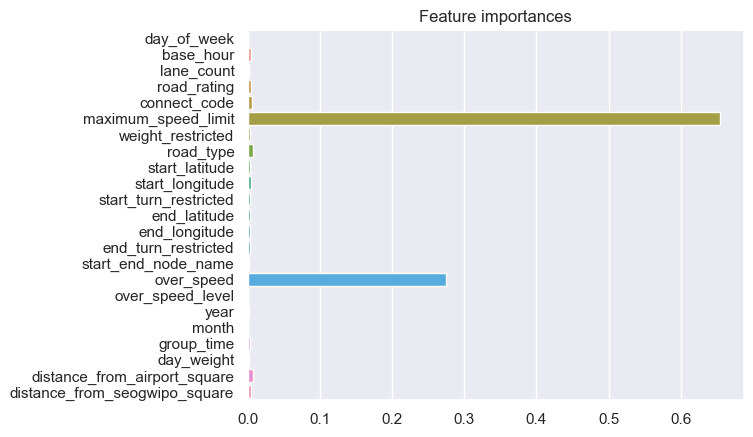

In [272]:
import matplotlib.pyplot as plt

feature_names = X_train.columns
importances = xgb_model.feature_importances_
sns.barplot(y=feature_names, x=importances, estimator=np.mean)
plt.title("Feature importances")
plt.show()

### 추론 & 제출

In [273]:
xgb_pred = xgb_model.predict(X_test)
submission_xgb = pd.read_csv('./data/sample_submission.csv')
submission_xgb['target'] = xgb_pred
submission_xgb.to_csv("./data/submit_xgb_final.csv", index = False)

### LGBM 파라미터 튜닝 다른 버전

In [274]:
import lightgbm as lgb

lgb_model = lgb.LGBMRegressor(n_estimators=50000, 
                              num_leaves = 128, 
                              subsample=0.6,
                              colsample_bytree=0.7,
                              reg_lambda=15,
                              random_state=20)


lgb_model.fit(X_tr, y_tr,
                eval_set=[(X_val, y_val)],
                eval_metric='l1',
                verbose=500,
                early_stopping_rounds=500)    


from sklearn.metrics import mean_absolute_error
print(f"훈련 셋: {mean_absolute_error(y_tr, lgb_model.predict(X_tr))}")
print(f"검증 셋: {mean_absolute_error(y_val, lgb_model.predict(X_val))}")

[500]	valid_0's l1: 3.22065	valid_0's l2: 21.2323
[1000]	valid_0's l1: 3.14272	valid_0's l2: 20.4671
[1500]	valid_0's l1: 3.10574	valid_0's l2: 20.092
[2000]	valid_0's l1: 3.08511	valid_0's l2: 19.8804
[2500]	valid_0's l1: 3.07007	valid_0's l2: 19.728
[3000]	valid_0's l1: 3.05883	valid_0's l2: 19.6132
[3500]	valid_0's l1: 3.05056	valid_0's l2: 19.5282
[4000]	valid_0's l1: 3.04435	valid_0's l2: 19.4697
[4500]	valid_0's l1: 3.03887	valid_0's l2: 19.4159
[5000]	valid_0's l1: 3.03398	valid_0's l2: 19.3686
[5500]	valid_0's l1: 3.03063	valid_0's l2: 19.3372
[6000]	valid_0's l1: 3.02725	valid_0's l2: 19.3056
[6500]	valid_0's l1: 3.024	valid_0's l2: 19.2762
[7000]	valid_0's l1: 3.02196	valid_0's l2: 19.2585
[7500]	valid_0's l1: 3.01999	valid_0's l2: 19.243
[8000]	valid_0's l1: 3.01812	valid_0's l2: 19.2288
[8500]	valid_0's l1: 3.01686	valid_0's l2: 19.2227
[9000]	valid_0's l1: 3.01589	valid_0's l2: 19.218
[9500]	valid_0's l1: 3.0146	valid_0's l2: 19.2077
[10000]	valid_0's l1: 3.01358	valid_0's

In [275]:
print(f"val mae: {mean_absolute_error(y_val, lgb_model.predict(X_val))}")
print(f"val r2_score: {r2_score(y_val, lgb_model.predict(X_val))}")

val mae: 3.0130135130379117
val r2_score: 0.9246353903968363


In [ ]:
print(f"val r2_score: {r2_score(y_val, lgb_model.predict(X_val))}")

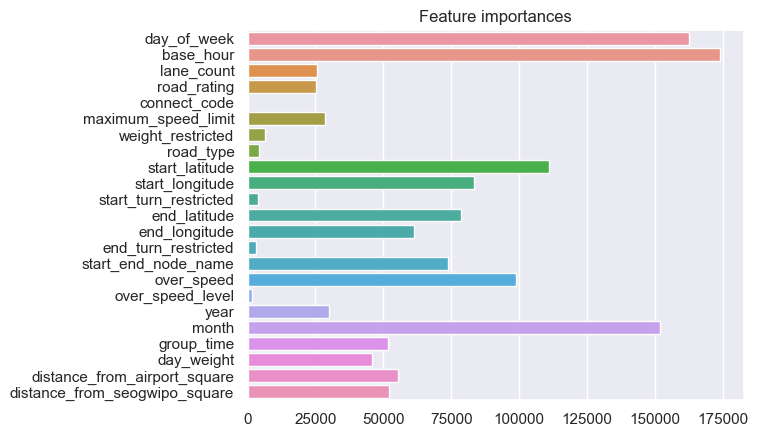

In [276]:
import matplotlib.pyplot as plt

feature_names = X_train.columns
importances = lgb_model.feature_importances_
sns.barplot(y=feature_names, x=importances, estimator=np.mean)
plt.title("Feature importances")
plt.show()

### 추론 & 제출

In [277]:
lgb_pred = lgb_model.predict(X_test)
submission_lgb = pd.read_csv('./data/sample_submission.csv')
submission_lgb['target'] = lgb_pred
submission_lgb.to_csv("./data/submit_lgb_final.csv", index = False)

### 앙상블 (xgb + lgb)

In [279]:
sample_submission = pd.read_csv('./data/sample_submission.csv')
sample_submission['target'] = np.round((submission_xgb['target'] + submission_lgb['target'])  / 2)
sample_submission.to_csv("./data/submit_ensem.csv", index = False)  